In [44]:
# pip3 install auto-sklearn
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    mean_squared_log_error,
    explained_variance_score
)
import sklearn.model_selection
import autosklearn.regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint

## Data Loading

Split한 데이터로 진행

In [45]:
# 데이터 불러오기
df = pd.read_csv('melb_split.csv')

# 데이터셋 분리
train_data = df[df['Split'] == 'Train']
test_data = df[df['Split'] == 'Test']

# 타겟 변수와 특성 분리
y_train = train_data['Price']
X_train = train_data.drop(['Price', 'Split'], axis=1)

y_test = test_data['Price']
X_test = test_data.drop(['Price', 'Split'], axis=1)

# 결과 확인
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10864, 20), (10864,), (2716, 20), (2716,))

In [46]:
X_train.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                52
Landsize            0
BuildingArea     5193
YearBuilt        4312
CouncilArea      1122
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

## Build and fit a regressor

In [47]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120, # 전체 작업 시간 제한 (초 단위)
    per_run_time_limit=50, # 각 모델의 시간 제한 (초 단위)
    tmp_folder="/data/ephemeral/home/Sojeong/melb/tmp/autosklearn_regression_example_tmp", # 임시 폴더 경로 
)
automl.fit(X_train, y_train, dataset_name="melb")

/data/ephemeral/conda_envs/sklearn-env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Column Suburb has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  warnings.warn(
/data/ephemeral/conda_envs/sklearn-env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Column Address has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  warnings.warn(
/data/ephemeral/conda_envs/sklearn-env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Column Type has generic type object. Autosklearn will treat this column as string. Please ensure that this setting is suitable for your task.
  warnings.warn(
/data/ephemeral/conda_envs/sklearn-env/lib/python3.9/site-packages/autosklearn/data/feature_validator.py:318: UserWarning: Input Co

[WARNING] [2025-01-17 02:49:17,610:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-01-17 02:49:22,113:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     per_run_time_limit=50, time_left_for_this_task=120,
                     tmp_folder='/data/ephemeral/home/Sojeong/melb/tmp/autosklearn_regression_example_tmp')

## View the models found by auto-sklearn

In [48]:
print(automl.leaderboard())

          rank  ensemble_weight               type      cost   duration
model_id                                                               
4            1              1.0  gradient_boosting  0.490288  31.198453


## Print the final ensemble constructed by auto-sklearn

In [49]:
pprint(automl.show_models(), indent=4)
# cost : 1 - R²
# HistGradientBoostingRegressor
'''
l2_regularization=3.1008e-10: L2 정규화 강도(과적합 방지).
learning_rate=0.974: 학습률.
max_iter=512: 최대 학습 반복 횟수.
max_leaf_nodes=76: 트리의 최대 잎 노드 개수.
min_samples_leaf=8: 잎 노드에 있어야 하는 최소 샘플 수.
validation_fraction=0.085: 검증 세트로 사용할 데이터 비율.
warm_start=True: 이전 학습 상태를 재사용해 학습 가속화.
'''

{   4: {   'cost': 0.4902881406643862,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f98b2296490>,
           'ensemble_weight': 1.0,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f989ead5a60>,
           'model_id': 4,
           'rank': 1,
           'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f989ead5d00>,
           'sklearn_regressor': HistGradientBoostingRegressor(l2_regularization=3.1008789875481045e-10,
                              learning_rate=0.9742767231340886, max_iter=512,
                              max_leaf_nodes=76, min_samples_leaf=8,
                              random_state=1,
                              validation_fraction=0.08508571055472691,
                              warm_start=True)}}


'\nl2_regularization=3.1008e-10: L2 정규화 강도(과적합 방지).\nlearning_rate=0.974: 학습률.\nmax_iter=512: 최대 학습 반복 횟수.\nmax_leaf_nodes=76: 트리의 최대 잎 노드 개수.\nmin_samples_leaf=8: 잎 노드에 있어야 하는 최소 샘플 수.\nvalidation_fraction=0.085: 검증 세트로 사용할 데이터 비율.\nwarm_start=True: 이전 학습 상태를 재사용해 학습 가속화.\n'

## Get the Score of the final ensemble

In [50]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Train R2 score: 0.8444611880916256
Test R2 score: 0.5329898486981202


In [51]:
# 평가 함수 정의
def evaluate_regression(y_true, y_pred, dataset_name="Dataset"):
    print(f"\nEvaluation for {dataset_name}:")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_true, y_pred):.4f}")
    print(f"Root Mean Squared Error (RMSE): {mean_squared_error(y_true, y_pred, squared=False):.4f}")
    print(f"Median Absolute Error (MedAE): {median_absolute_error(y_true, y_pred):.4f}")
    try:
        print(f"Mean Squared Log Error (MSLE): {mean_squared_log_error(y_true, y_pred):.4f}")
    except ValueError:
        print("Mean Squared Log Error (MSLE): Not defined for negative values.")
    print(f"Explained Variance Score: {explained_variance_score(y_true, y_pred):.4f}")

# Train 데이터 평가
evaluate_regression(y_train, train_predictions, "Train Data")

# Test 데이터 평가
evaluate_regression(y_test, test_predictions, "Test Data")


Evaluation for Train Data:
R2 Score: 0.8445
Mean Absolute Error (MAE): 99013.2980
Mean Squared Error (MSE): 64003625196.1378
Root Mean Squared Error (RMSE): 252989.3776
Median Absolute Error (MedAE): 0.0000
Mean Squared Log Error (MSLE): 0.0633
Explained Variance Score: 0.8445

Evaluation for Test Data:
R2 Score: 0.5330
Mean Absolute Error (MAE): 298953.9314
Mean Squared Error (MSE): 185603678423.9001
Root Mean Squared Error (RMSE): 430817.4537
Median Absolute Error (MedAE): 207076.6719
Mean Squared Log Error (MSLE): 0.1988
Explained Variance Score: 0.5330


## Plot the predictions

In [52]:
nan_count = np.isnan(train_predictions).sum()
print(f"Number of NaN values in train_predictions: {nan_count}")

Number of NaN values in train_predictions: 0


In [53]:
print("Train predictions range:", train_predictions.min(), "-", train_predictions.max())
print("Test predictions range:", test_predictions.min(), "-", test_predictions.max())
print("y_train range:", y_train.min(), "-", y_train.max())
print("y_test range:", y_test.min(), "-", y_test.max())

Train predictions range: 65500.0 - 9000000.0
Test predictions range: 65500.0 - 5631532.0
y_train range: 85000.0 - 9000000.0
y_test range: 185000.0 - 5600000.0


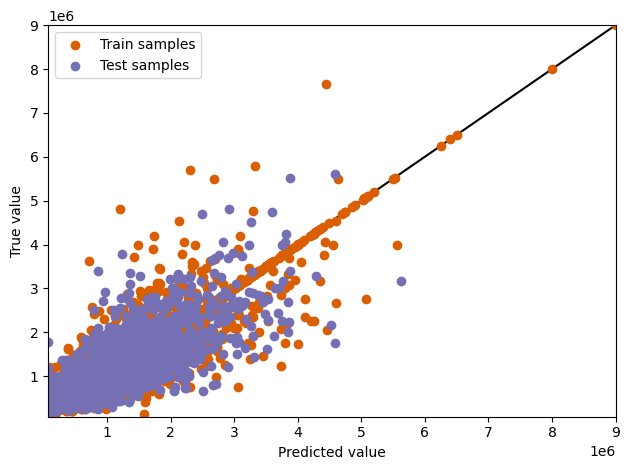

In [54]:
plt.scatter(train_predictions, y_train, label="Train samples", c="#d95f02")
plt.scatter(test_predictions, y_test, label="Test samples", c="#7570b3")
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()

# 범위 지정: x축은 예측값, y축은 실제값 기준
plt.xlim([75000, 9000000])  # x축 범위 (train_predictions, test_predictions에 맞춤)
plt.ylim([75000, 9000000])  # y축 범위 (y_train, y_test에 맞춤)

# 대각선 표시 (예측값 = 실제값 선)
plt.plot([75000, 9000000], [75000, 9000000], c="k", zorder=0)

plt.tight_layout()
plt.show()

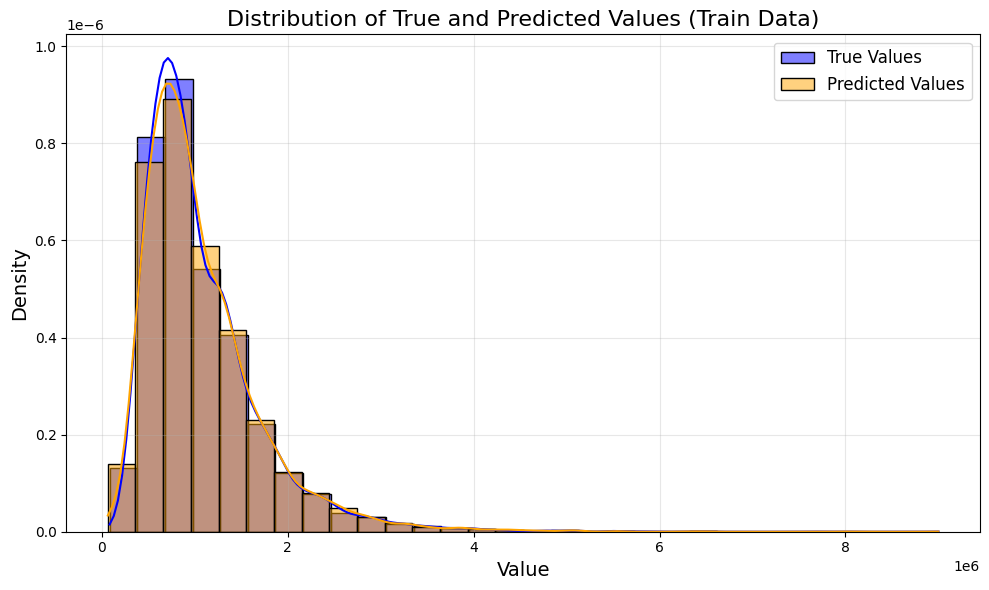

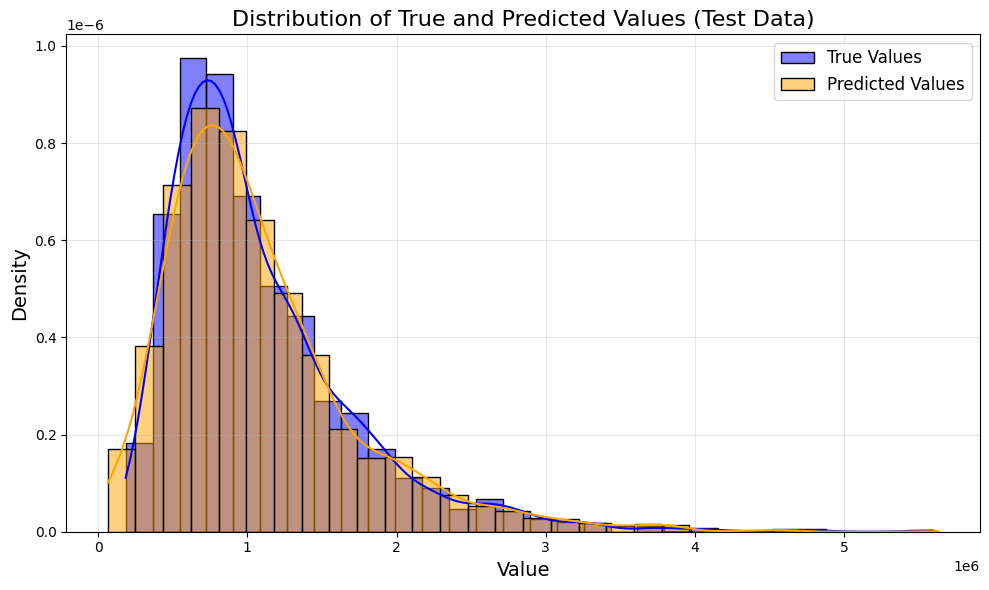

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# 분포 비교 함수 정의
def plot_distribution(y_true, y_pred, dataset_name="Dataset"):
    plt.figure(figsize=(10, 6))
    
    # 히스토그램 및 커널 밀도 추정 (KDE)
    sns.histplot(y_true, label="True Values", color="blue", kde=True, stat="density", bins=30, alpha=0.5)
    sns.histplot(y_pred, label="Predicted Values", color="orange", kde=True, stat="density", bins=30, alpha=0.5)
    
    # 그래프 꾸미기
    plt.title(f"Distribution of True and Predicted Values ({dataset_name})", fontsize=16)
    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Train 데이터 분포 비교
plot_distribution(y_train, train_predictions, "Train Data")

# Test 데이터 분포 비교
plot_distribution(y_test, test_predictions, "Test Data")

In [56]:
# 학습된 모델 파이프라인 보기
print(automl.show_models())

{4: {'model_id': 4, 'rank': 1, 'cost': 0.4902881406643862, 'ensemble_weight': 1.0, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f98b2296490>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f989ead5a60>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f989ead5d00>, 'sklearn_regressor': HistGradientBoostingRegressor(l2_regularization=3.1008789875481045e-10,
                              learning_rate=0.9742767231340886, max_iter=512,
                              max_leaf_nodes=76, min_samples_leaf=8,
                              random_state=1,
                              validation_fraction=0.08508571055472691,
                              warm_start=True)}}
